# Initial imports

In [73]:
import glob
import os,subprocess,shutil,fnmatch
import numpy as np
import scipy as sp
import scipy.cluster as cluster
import pandas as pd
import re,itertools
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from matplotlib import colors
from matplotlib import animation, rc
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
from IPython.display import HTML,Image

In [4]:
# Plot size
from pylab import rcParams
rcParams['figure.figsize'] = (20.0,15.0)
#sns.set_style(style='white')
#plt.ioff()

In [5]:
pd.set_option('display.max_rows', 100)

In [75]:
clrs = cm.tab20b.colors+cm.tab20c.colors[:4]

cmap = matplotlib.colors.ListedColormap(clrs)

## TSNE, KMeans

In [6]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import sklearn.decomposition as skd
from sklearn.metrics import silhouette_samples, silhouette_score

## Keras for deep learning functions

In [7]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model,load_model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
import argparse

Using TensorFlow backend.


## MATLAB engine

In [8]:
import matlab.engine
eng = matlab.engine.start_matlab()

## cd to directory with the ODF data

In [9]:
os.chdir('/home/srihari/Work/StatisticallearningofProcessSequences/Tension_Rolling/analysis/')

# Some functions

In [10]:
# Modified from stack overflow answer https://stackoverflow.com/a/22864350
# Returns the numbers from a string as a list
# Example split('p1a34b24') returns ['1', '34', '24']

def split(s):
    res = []

    def replace(matchobj):

        try:
            float(matchobj.group(0))
        except:
            return ''
        res.append(matchobj.group(0))
        

    letter = re.compile('^([a-z.]+)')
    number = re.compile('^([+-]?\d+(?:\.\d+)?)')

    if letter.match(s):
        c = itertools.cycle([letter, number])
    else:
        c = itertools.cycle([number, letter])

    for op in c:
        mods = op.sub(replace, s)
        if len(s) == len(mods):
            return 
        elif not mods:
            return res
        s = mods

In [11]:
def readTecplotODF(filename,nnodes):
    nodes=np.loadtxt(filename,skiprows=4)
    
    odf=nodes[:nnodes,-1]
    elements=nodes[nnodes:,:]-1
    nodes=nodes[:nnodes,:3]
    
    return odf,nodes,elements.astype(int)

In [12]:
def get_index(names,sequences):
    return [names.index(seq) for seq in sequences]

In [13]:
def distance(inputarray):
    return np.array([[np.linalg.norm(j-i) for j in inputarray] for i in inputarray])

In [14]:
def compute_property(ODFarray,property_Matrix):
    """Send in ODF(n*76) and property at every single crystal (76*36, for stiffness matrix)
       Output E_11 for each of the n ODFs
    """
    prop = ODFarray.dot(property_Matrix.T)

    E_11 = [1/np.linalg.inv(np.reshape(prop,[ODFarray.shape[0],6,6])[i])[0,0] for i in range(ODFarray.shape[0])]

    E_11 = np.array(E_11)
    
    return E_11

In [92]:
def plot_results(points,
                 color
                ):

    fig, ax = plt.subplots()

    ax.set_xlabel("z[0]")
    ax.set_ylabel("z[1]")
    #ax.colorbar()
    
    x = points[:,0]
    y = points[:,1]
    
    scat = ax.scatter(x, y,c=color,cmap=cmap)
    fig.colorbar(scat, ax=ax)
    #idx = np.where(y_test == 1)
    
    def animate(i):
        if(i==0):
            x = points[:,0]
            y = points[:,1]
            scat.set_offsets(np.c_[x,y])
            scat.set_array(color)
            return
        idx = np.where(color == i-1)
        ax.set_title("Process:"+str(i-1))
        x = points[idx[0],0]
        y = points[idx[0],1]
        scat.set_offsets(np.c_[x,y])
        scat.set_array(color[idx[0]])
        
        
    anim = animation.FuncAnimation(fig, animate,interval=500,frames=int(np.max(color))+2)
                                   #blit=True)
    return anim

# Read data
### Sequence information

In [15]:
files=glob.iglob('database/*.txt')
names=[filename for filename in os.listdir("database/") if fnmatch.fnmatch(filename, "*.txt")]

In [16]:
names1 = [name[:-len('.txt')] for name in names]

In [42]:
#pnames=['TensionX','TensionY','TensionZ','RollingX','RollingY','RollingZ']
pnames=['Tension X','Tension Y','Tension Z','Rolling YX','Rolling ZY','Rolling XZ']
alphas=['-1.0','-0.5','0.5','1.0']

processes=[split(processname) for processname in names]

In [41]:
processing_info = pd.read_csv('4stages/processing_info.txt',usecols=range(1,9))

In [43]:
proc24 = np.loadtxt('4stages/proc24.txt')

In [52]:
lastproc = np.loadtxt('4stages/lastproc.txt')

### ODF data

In [54]:
stackedODFs=np.loadtxt('4stages/allodfs.txt')

In [55]:
ODF_minussymmetry=stackedODFs[:,:76]

In [56]:
# Volume fraction corresponding to every node of the ODF
volFracs = np.array([0.015982 , 0.0081818, 0.0081818, 0.0081818, 0.0081818, 0.0081818,
       0.0081818, 0.0061377, 0.0057265, 0.0057265, 0.0061377, 0.0057265,
       0.0057265, 0.0057265, 0.0061377, 0.0057265, 0.0057265, 0.0057265,
       0.0057265, 0.0057265, 0.0061377, 0.0057265, 0.0061377, 0.0057265,
       0.0057265, 0.0057265, 0.0057265, 0.0057265, 0.0061377, 0.0061377,
       0.0061377, 0.0037614, 0.0037614, 0.0037614, 0.0045408, 0.0045408,
       0.0045408, 0.0045408, 0.0045408, 0.0045408, 0.0045408, 0.0045408,
       0.0045408, 0.0045408, 0.0045408, 0.0045408, 0.0045408, 0.0045408,
       0.0045408, 0.0045408, 0.0045408, 0.0045408, 0.0045408, 0.0045408,
       0.0045408, 0.0045408, 0.0045408, 0.0045408, 0.0054119, 0.0049554,
       0.0049554, 0.0054119, 0.0049554, 0.0054119, 0.0054119, 0.0054119,
       0.0054119, 0.0054119, 0.0049554, 0.0054119, 0.003982 , 0.003982 ,
       0.003982 , 0.003982 , 0.003982 , 0.003982 ])

# Plot process sequence

In [414]:
try:
    os.chdir('processsequenceplottingforpaper')

    files=glob.iglob('p*.txt')

    ODFstopolot=np.array([np.loadtxt(f) for f in files])
    os.chdir('/home/srihari/Work/StatisticallearningofProcessSequences/Tension_Rolling/analysis/')    
except Exception as e: 
    print(e)
    os.chdir('/home/srihari/Work/StatisticallearningofProcessSequences/Tension_Rolling/analysis/')

In [415]:
fname = 'getthisplotted'

np.savetxt(fname+'.txt',ODFstopolot)

eng.plotODF_76_separate(fname+'.txt',fname+'.png',fname+'1.png',0,nargout=0)


In [416]:
os.chdir('/home/srihari/Work/StatisticallearningofProcessSequences/Tension_Rolling/analysis/')

In [417]:
files=glob.iglob('processsequenceplottingforpaper/p*.txt')
[f for f in files]

['processsequenceplottingforpaper/p2a3p6a1p3a2.txt',
 'processsequenceplottingforpaper/p2a3p5a4p1a1.txt',
 'processsequenceplottingforpaper/p2a3p5a4.txt',
 'processsequenceplottingforpaper/p2a3p5a4p1a1p4a2.txt',
 'processsequenceplottingforpaper/p2a3p6a1.txt',
 'processsequenceplottingforpaper/p2a3.txt']

# Property coloring

In [58]:
propMat = np.loadtxt('ALdata.txt',delimiter=',')

In [59]:
E_11 = compute_property(ODF_minussymmetry,propMat)

# Split dataset into train, validation and test

In [62]:
traininigset_rows = np.loadtxt('4stages/trainingrows.txt').astype(int)
validateset_rows = np.loadtxt('4stages/validationrows.txt').astype(int)
testset_rows = np.loadtxt('4stages/testingrows.txt').astype(int)

# Variational auto encoder

In [25]:
# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [27]:
def train_VAE(ODFinput,latent_dim,verbose=1,normalizing_mode=0):
    original_dim = ODFinput.shape[1]
    if normalizing_mode == 1:
        x_train = ODFinput/np.mean(ODFinput[:,:76])
    else:
        x_train = ODFinput/np.max(ODFinput)
    #x_train = (ODFinput-np.min(ODFinput))/(np.max(ODFinput)-np.min(ODFinput))
    #x_test = np.reshape(x_test, [-1, original_dim])

    # network parameters
    input_shape = (original_dim,)
    intermediate_dim1 = 45
    intermediate_dim2 = 15
    batch_size = 64
    #latent_dim = 2
    epochs = 50

    # VAE model = encoder + decoder
    # build encoder model
    inputs = Input(shape=input_shape, name='encoder_input')
    x = Dense(intermediate_dim1, activation='relu')(inputs)
    x = Dense(intermediate_dim2, activation='sigmoid')(x)
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # instantiate encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    #encoder.summary()
    plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

    # build decoder model
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x1 = Dense(intermediate_dim2, activation='relu')(latent_inputs)
    x = Dense(intermediate_dim1, activation='relu')(x1)
    outputs = Dense(original_dim, activation='tanh')(x)

    # instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    #decoder.summary()
    plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

    # instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae_mlp')

    if __name__ == '__main__':
        models = (encoder, decoder)

        # VAE loss = mse_loss or xent_loss + kl_loss
        #if args.mse:
        #    reconstruction_loss = mse(inputs, outputs)
        #else:
        reconstruction_loss = binary_crossentropy(inputs,
                                                      outputs)

        reconstruction_loss *= original_dim
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        vae.add_loss(vae_loss)
        vae.compile(optimizer='adam')
        #vae.summary()
        plot_model(vae,
                   to_file='vae_mlp.png',
                   show_shapes=True)

        #if args.weights:
        #    vae.load_weights(args.weights)
        #else:
        # train the autoencoder
        if(verbose):
            vae.fit(x_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    #verbose=0
                    )
        else:
            vae.fit(x_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=0
                    )

        #vae.save_weights('vae_mlp_mnist.h5')

#        plot_results(models,
#                     data,
#                     batch_size=batch_size,
#                     model_name="vae_mlp")
        
        return vae, encoder, decoder

## Train the models

In [57]:
vae_ndim = {}
encoder_ndim = {}
decoder_ndim = {}
for ndim in range(1,6):
    
    print(ndim)
    
    encoder_ndim[ndim]=load_model('4stages/encoder_ndim_'+str(ndim)+'.h5')    
    decoder_ndim[ndim]=load_model('4stages/decoder_ndim_'+str(ndim)+'.h5')

1
Instructions for updating:
Colocations handled automatically by placer.


/home/srihari/.local/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


2
3
4
5


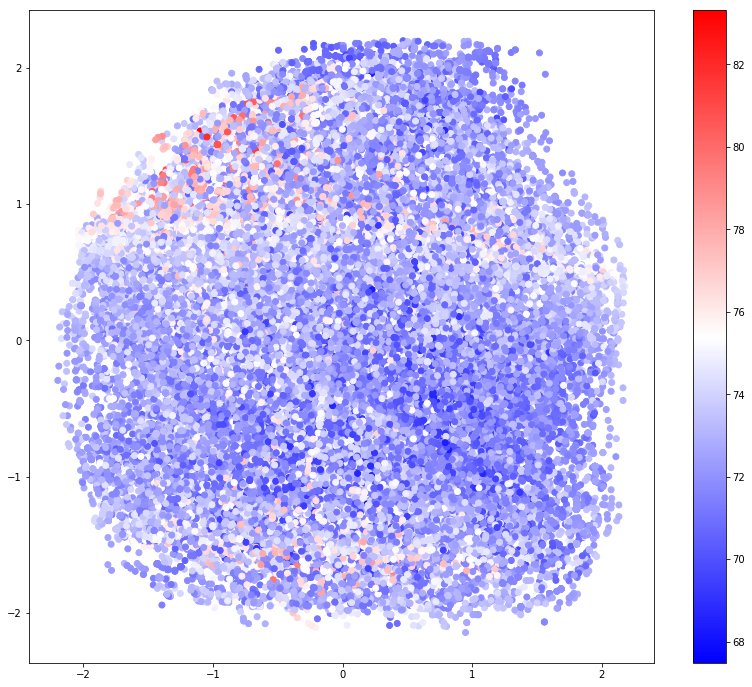

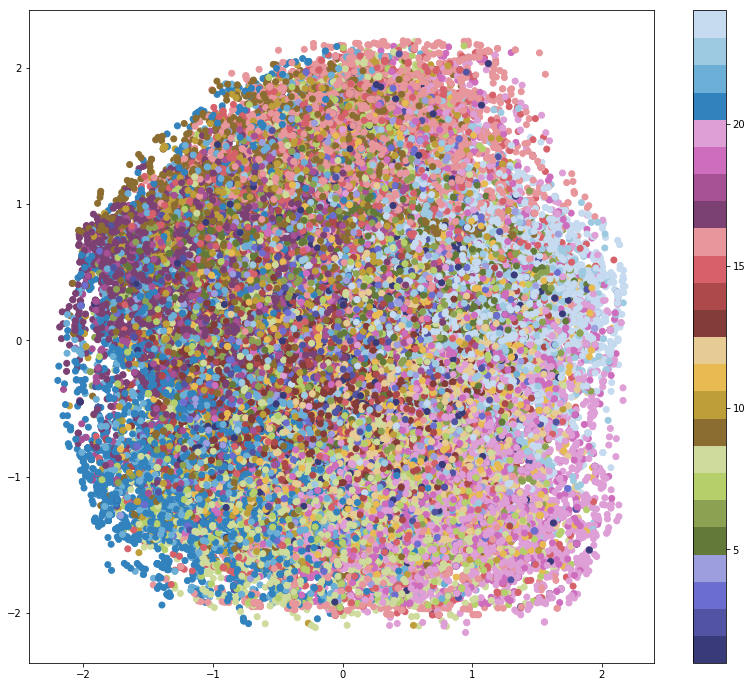

In [78]:
ndim=2
rcParams['figure.figsize'] = (14.0,12.0)
ODFinput = ODF_minussymmetry[traininigset_rows,:]
ODFinput_scaled = ODFinput/np.max(ODF_minussymmetry)
zm_all,zs_all,z_all = encoder_ndim[ndim].predict(ODFinput_scaled)

plt.scatter(zm_all[:,0],zm_all[:,1],c=E_11[traininigset_rows],cmap=cm.bwr)
plt.colorbar()
plt.savefig('2dlatentspace_training.png')
plt.show()

## Last process in each sequence

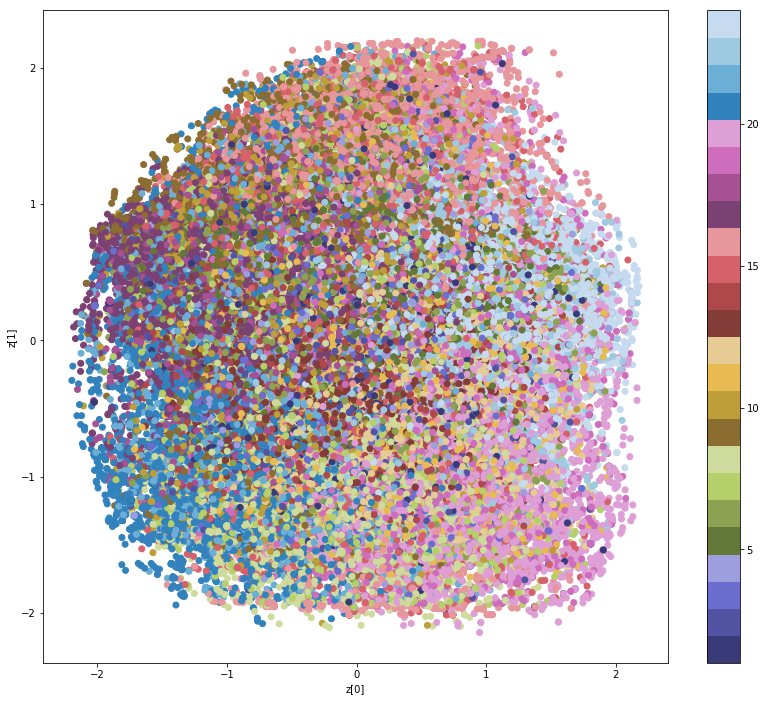

In [93]:
ndim=2
rcParams['figure.figsize'] = (14.0,12.0)
ODFinput = ODF_minussymmetry[traininigset_rows,:]
ODFinput_scaled = ODFinput/np.max(ODF_minussymmetry)
zm_all,zs_all,z_all = encoder_ndim[ndim].predict(ODFinput_scaled)


anim = plot_results(zm_all,lastproc[traininigset_rows])

In [94]:
HTML(anim.to_html5_video())

/home/srihari/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [96]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=2, metadata=dict(artist='Me'), bitrate=1800)

anim.save('24processes_2dlatentspace.mp4', writer=writer)

/home/srihari/.local/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


# Latent dimension variation

# Small window

## Validation set

In [97]:
#Find points between zm_0 = 1.1 and 1.3 and zm_1 = 1.1 and 1.3

ndim = 2
ODFinput = ODF_minussymmetry[validateset_rows]
ODFinput_scaled = ODFinput/np.max(ODF_minussymmetry)
zm,zs,z = encoder_ndim[ndim].predict(ODFinput_scaled)

indices = []
for idx,point in enumerate(zm):
        if(point[0]<1.30 and point[1]<1.30
            and point[0]>1.10 and point[1]>1.10):
            indices.append(validateset_rows[idx])


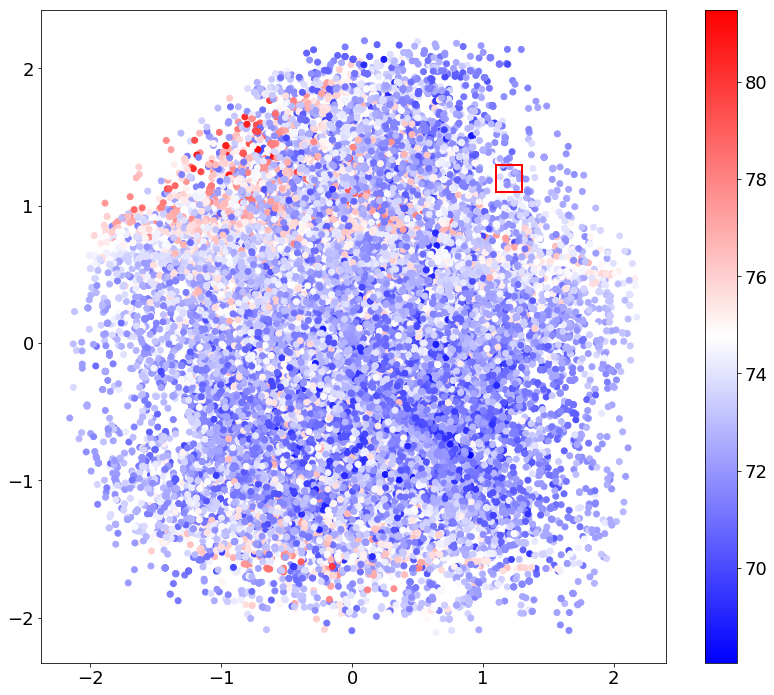

In [235]:
ndim=2
rcParams['figure.figsize'] = (14.0,12.0)
ODFinput = ODF_minussymmetry[validateset_rows,:]
ODFinput_scaled = ODFinput/np.max(ODF_minussymmetry)
zm_all,zs_all,z_all = encoder_ndim[ndim].predict(ODFinput_scaled)

fig,ax = plt.subplots(1)

im = ax.scatter(zm_all[:,0],zm_all[:,1],c=E_11[validateset_rows],cmap=cm.bwr)
fig.colorbar(im, ax=ax)

rect = patches.Rectangle((1.1,1.1),0.2,0.2,linewidth=2,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.savefig('validationlatentspace_windowODF.png')
plt.show()

In [519]:
windowODF_processdetails = processing_info.loc[indices].reset_index(drop=True)

windowODF_processdetails.index = np.arange(1, len(windowODF_processdetails) + 1)

windowODF_processdetails.to_latex('windowODF.tex')

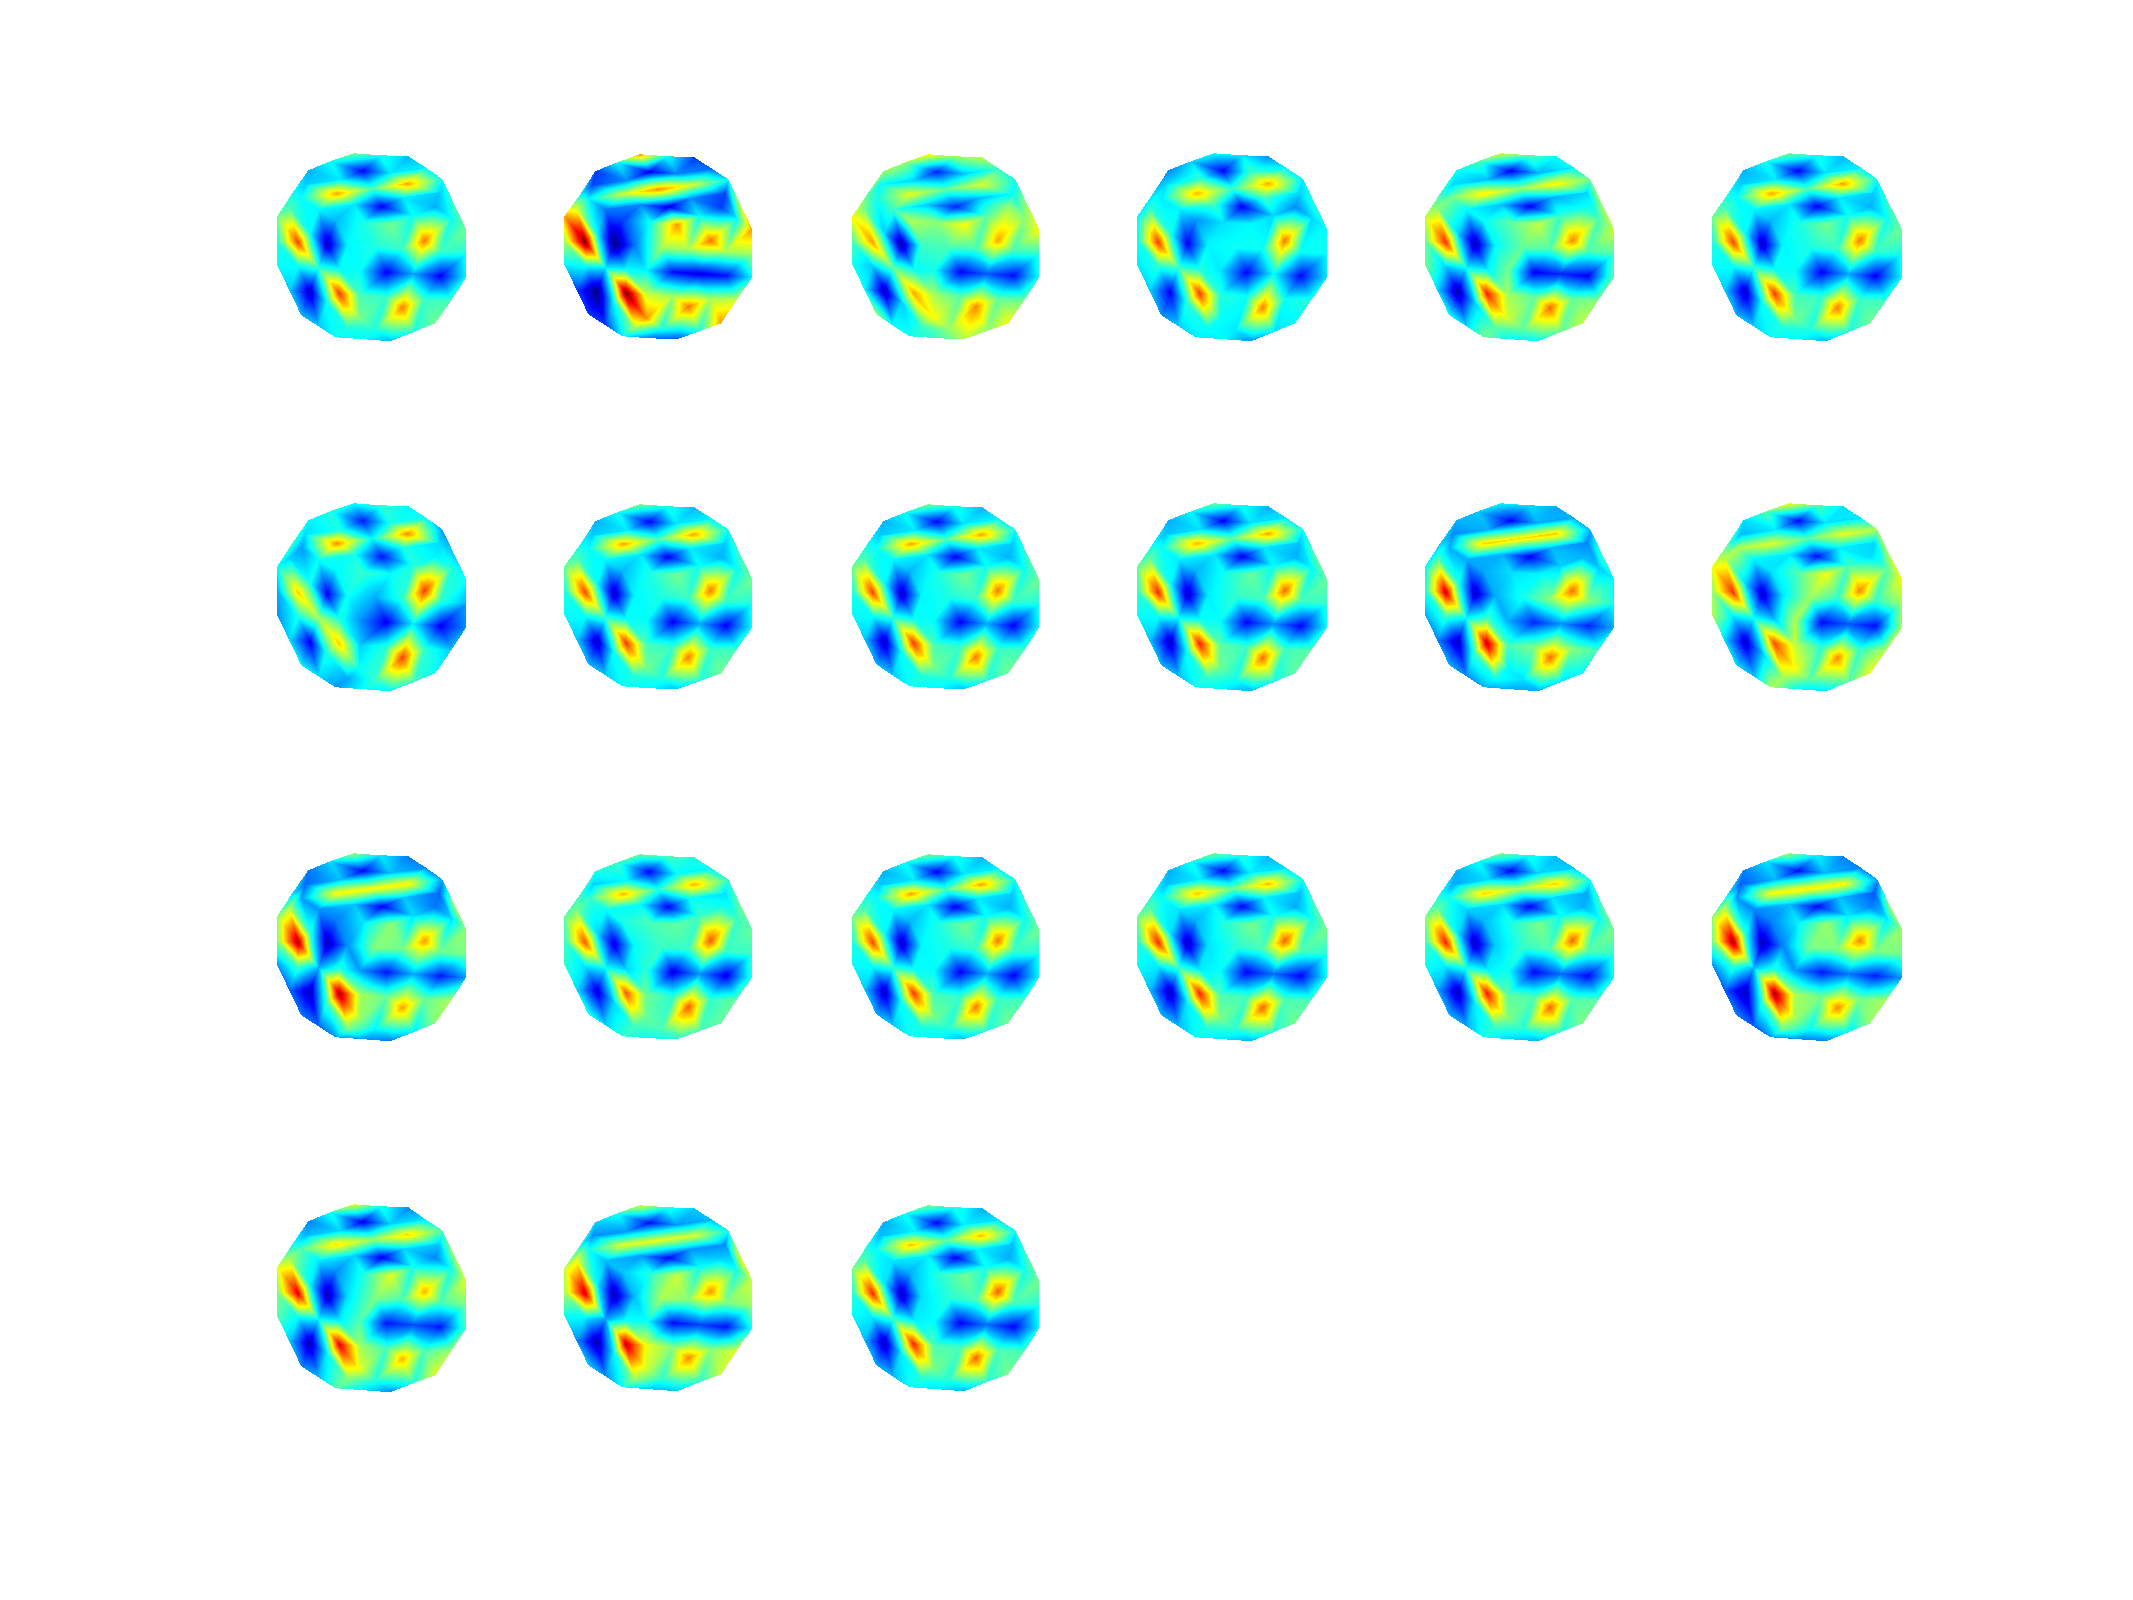

In [223]:
windowODF = ODF_minussymmetry[indices]

fname = 'windowODF'
np.savetxt(fname + '.txt',windowODF)

eng.plotODF_76(fname+'.txt',fname+'.png',0,nargout=0)

Image(filename=fname+'.png')

# Decode the space

In [208]:
x = np.linspace(-2,2,5)
y = np.linspace(2,-2,5)
xy = np.meshgrid(x,y)
xy_ = np.stack([a.reshape(-1) for a in xy]).T
ODFreturned_scaled = decoder_ndim[2].predict(xy_)
ODFreturned = (ODFreturned_scaled)*np.max(ODF_minussymmetry)
np.savetxt('spacegirdsampling.txt',ODFreturned)

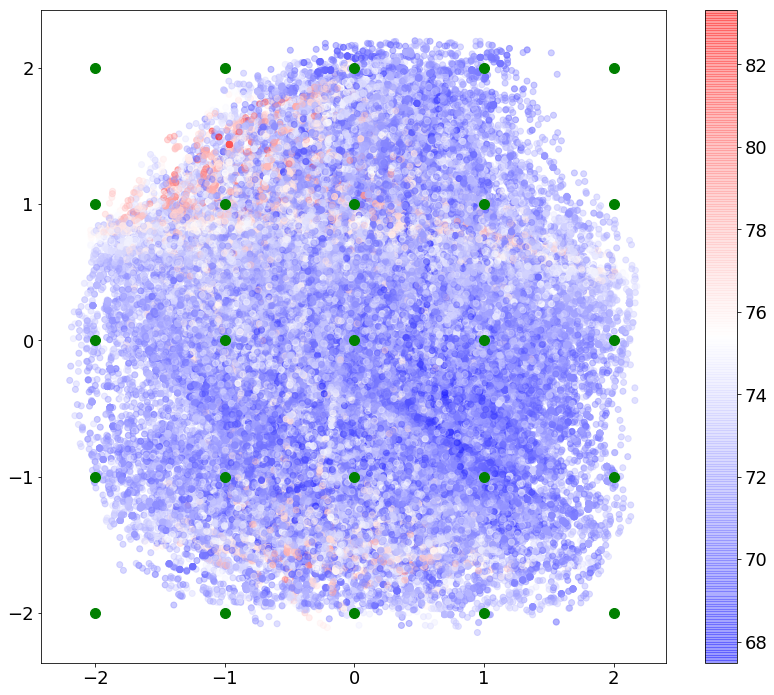

In [233]:
ndim=2
rcParams['figure.figsize'] = (14.0,12.0)
ODFinput = ODF_minussymmetry[traininigset_rows,:]
ODFinput_scaled = ODFinput/np.max(ODF_minussymmetry)
zm_all,zs_all,z_all = encoder_ndim[ndim].predict(ODFinput_scaled)

plt.scatter(zm_all[:,0],zm_all[:,1],c=E_11[traininigset_rows],alpha=0.4,cmap=cm.bwr)
#plt.axis('square')
#plt.xlim([-2.5,2.5])
#plt.ylim([-2.5,2.5])
plt.colorbar()

plt.scatter(xy_[:,0],xy_[:,1],c='g',s=100)

plt.savefig('samplingspace_grid.png')
plt.show()


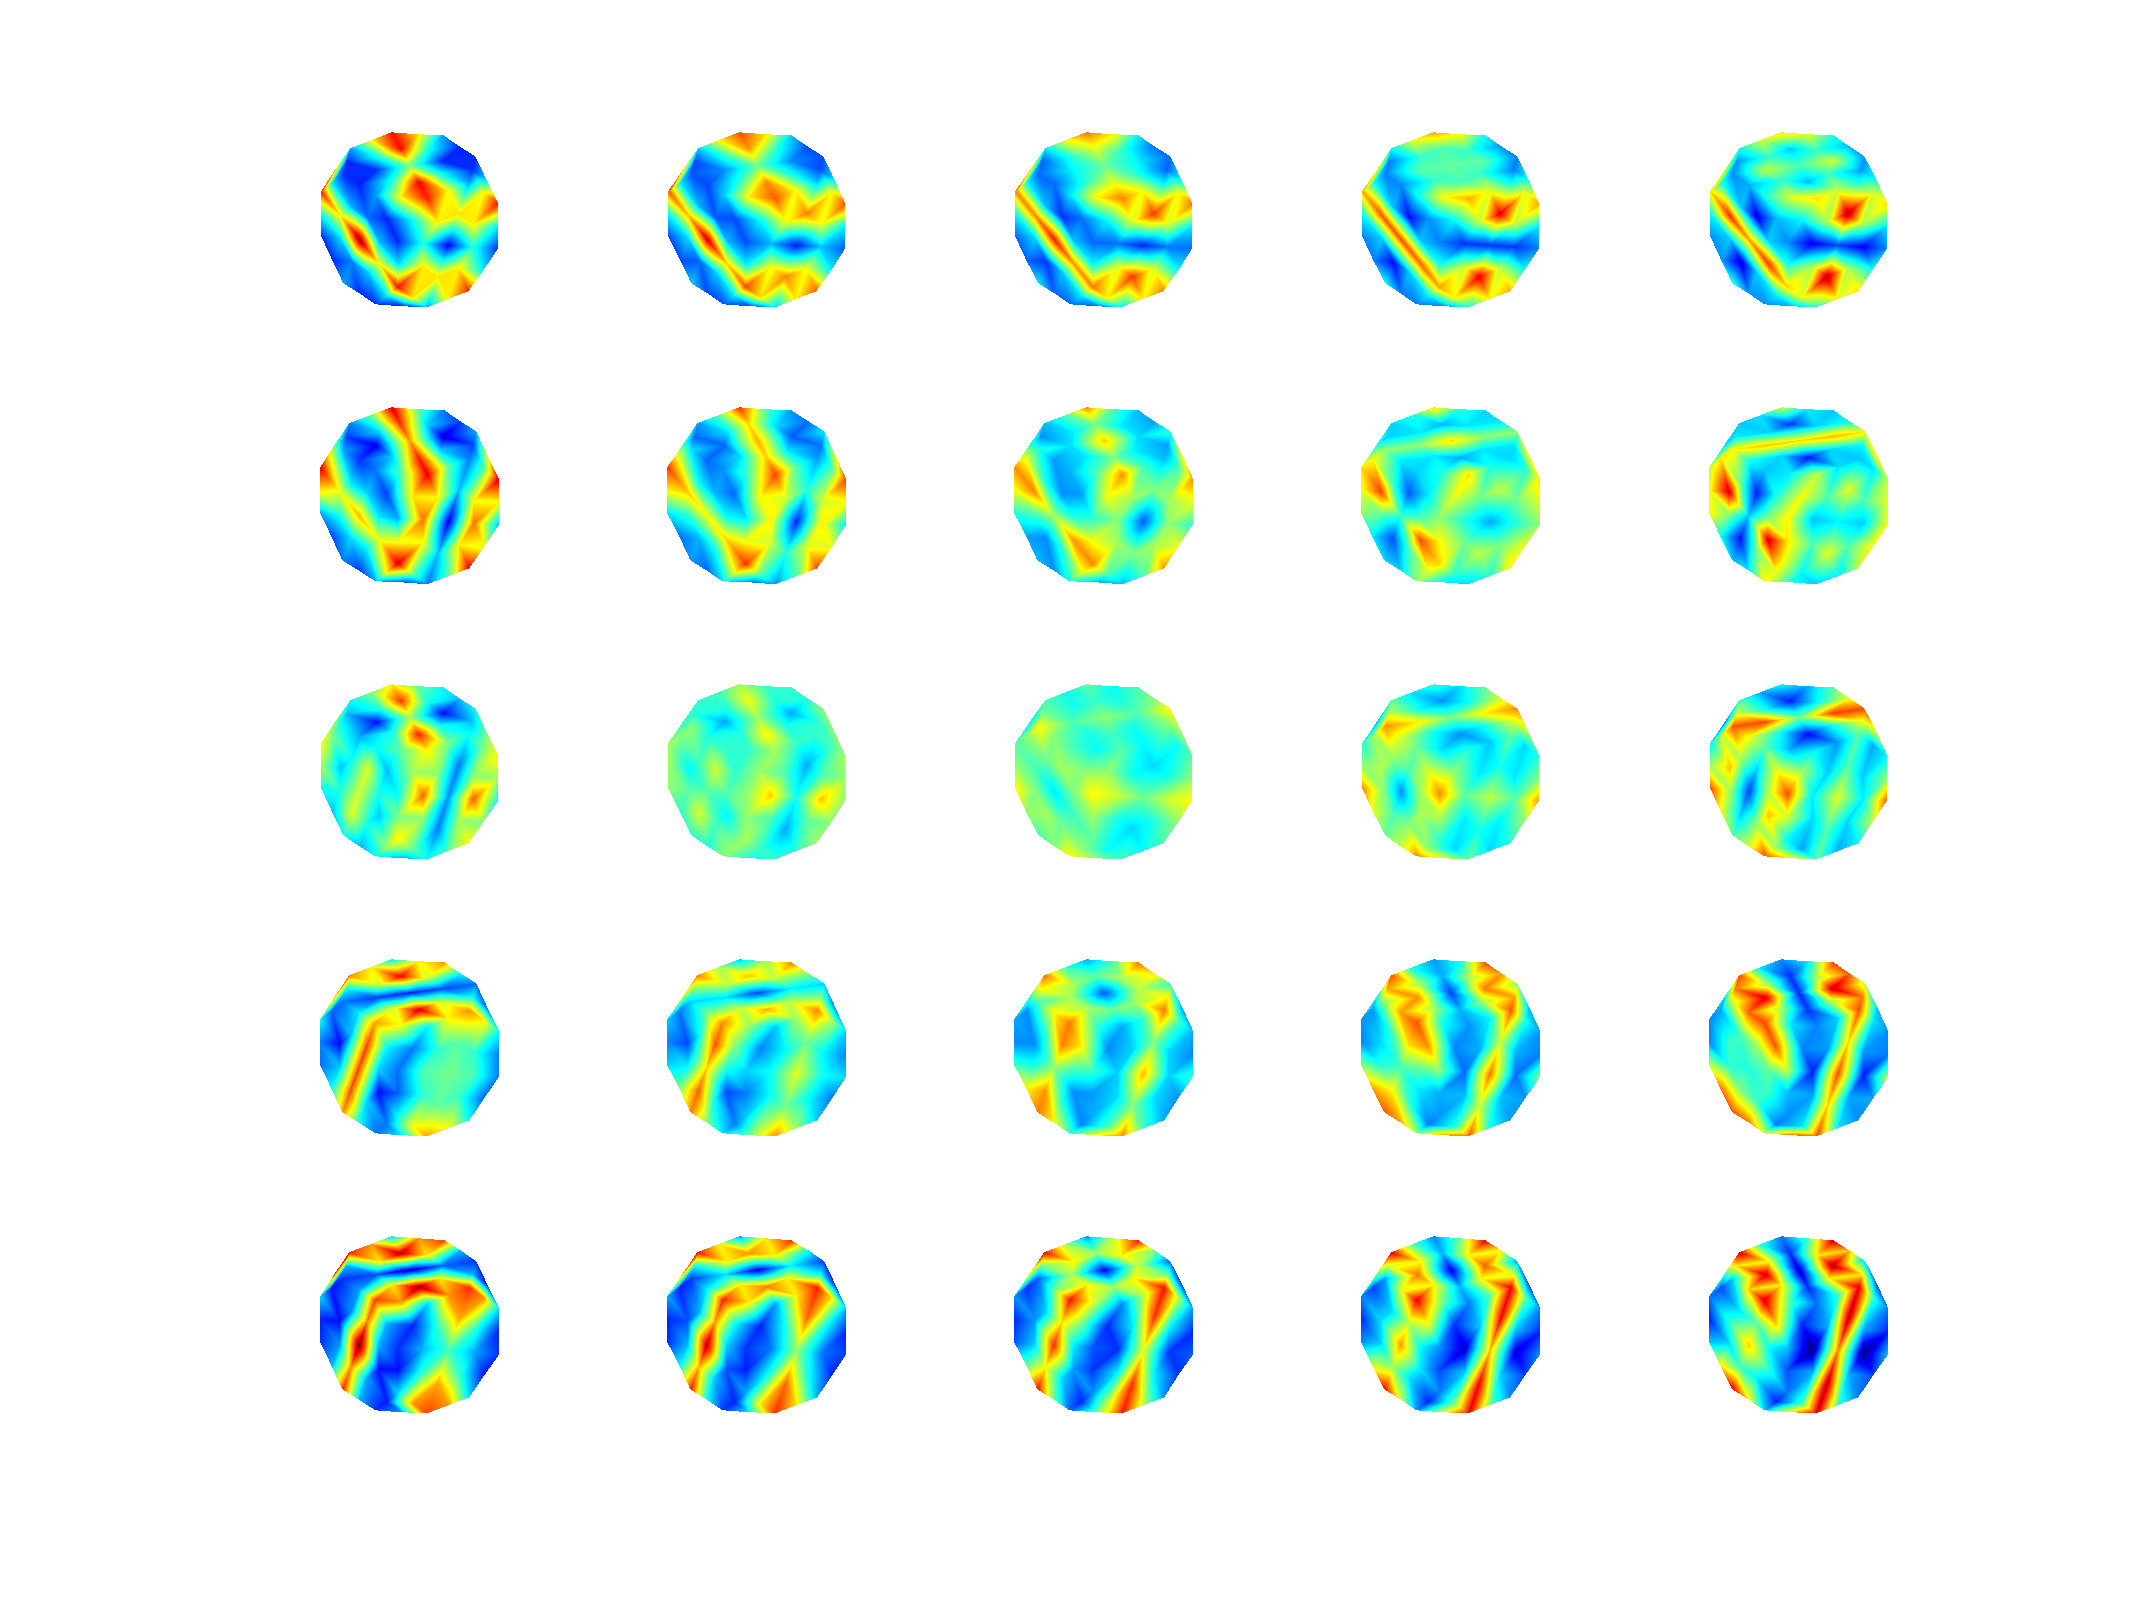

In [211]:
fname = 'spacegirdsampling'

eng.plotODF_76(fname+'.txt',fname+'.png',0,nargout=0)

Image(filename=fname+'.png')

## Qualitative comparison

In [ ]:
inputRows = np.random.choice(validateset_rows,5,replace=False)
ODFinput = ODF_minussymmetry[inputRows,:]
ODFtofile = ODFinput
ODFinput_scaled = ODFinput/np.max(ODF_minussymmetry)

for ndim in range(1,6):
    
    zm,zs,z = encoder_ndim[ndim].predict(ODFinput_scaled)
    ODFreturned_scaled = decoder_ndim[ndim].predict(zm)

    ODFreturned = (ODFreturned_scaled)*np.max(ODF_minussymmetry)

    print(np.linalg.norm(ODFreturned - ODFinput,axis=1))
    
    ODFtofile = np.append(ODFtofile,ODFreturned,axis=0)
     
    

In [138]:
fname = 'varylatendim'
ODFtofile = np.loadtxt('varylatendim.txt')

In [150]:
ODFtofile.shape

(30, 76)

In [151]:
varyLatentDimODFs.shape

(18, 76)

In [148]:
varyLatentDimODFs = np.reshape(np.swapaxes(np.reshape(ODFtofile,[6,5,-1])[:,[0,1,4]],0,1),[-1,76])

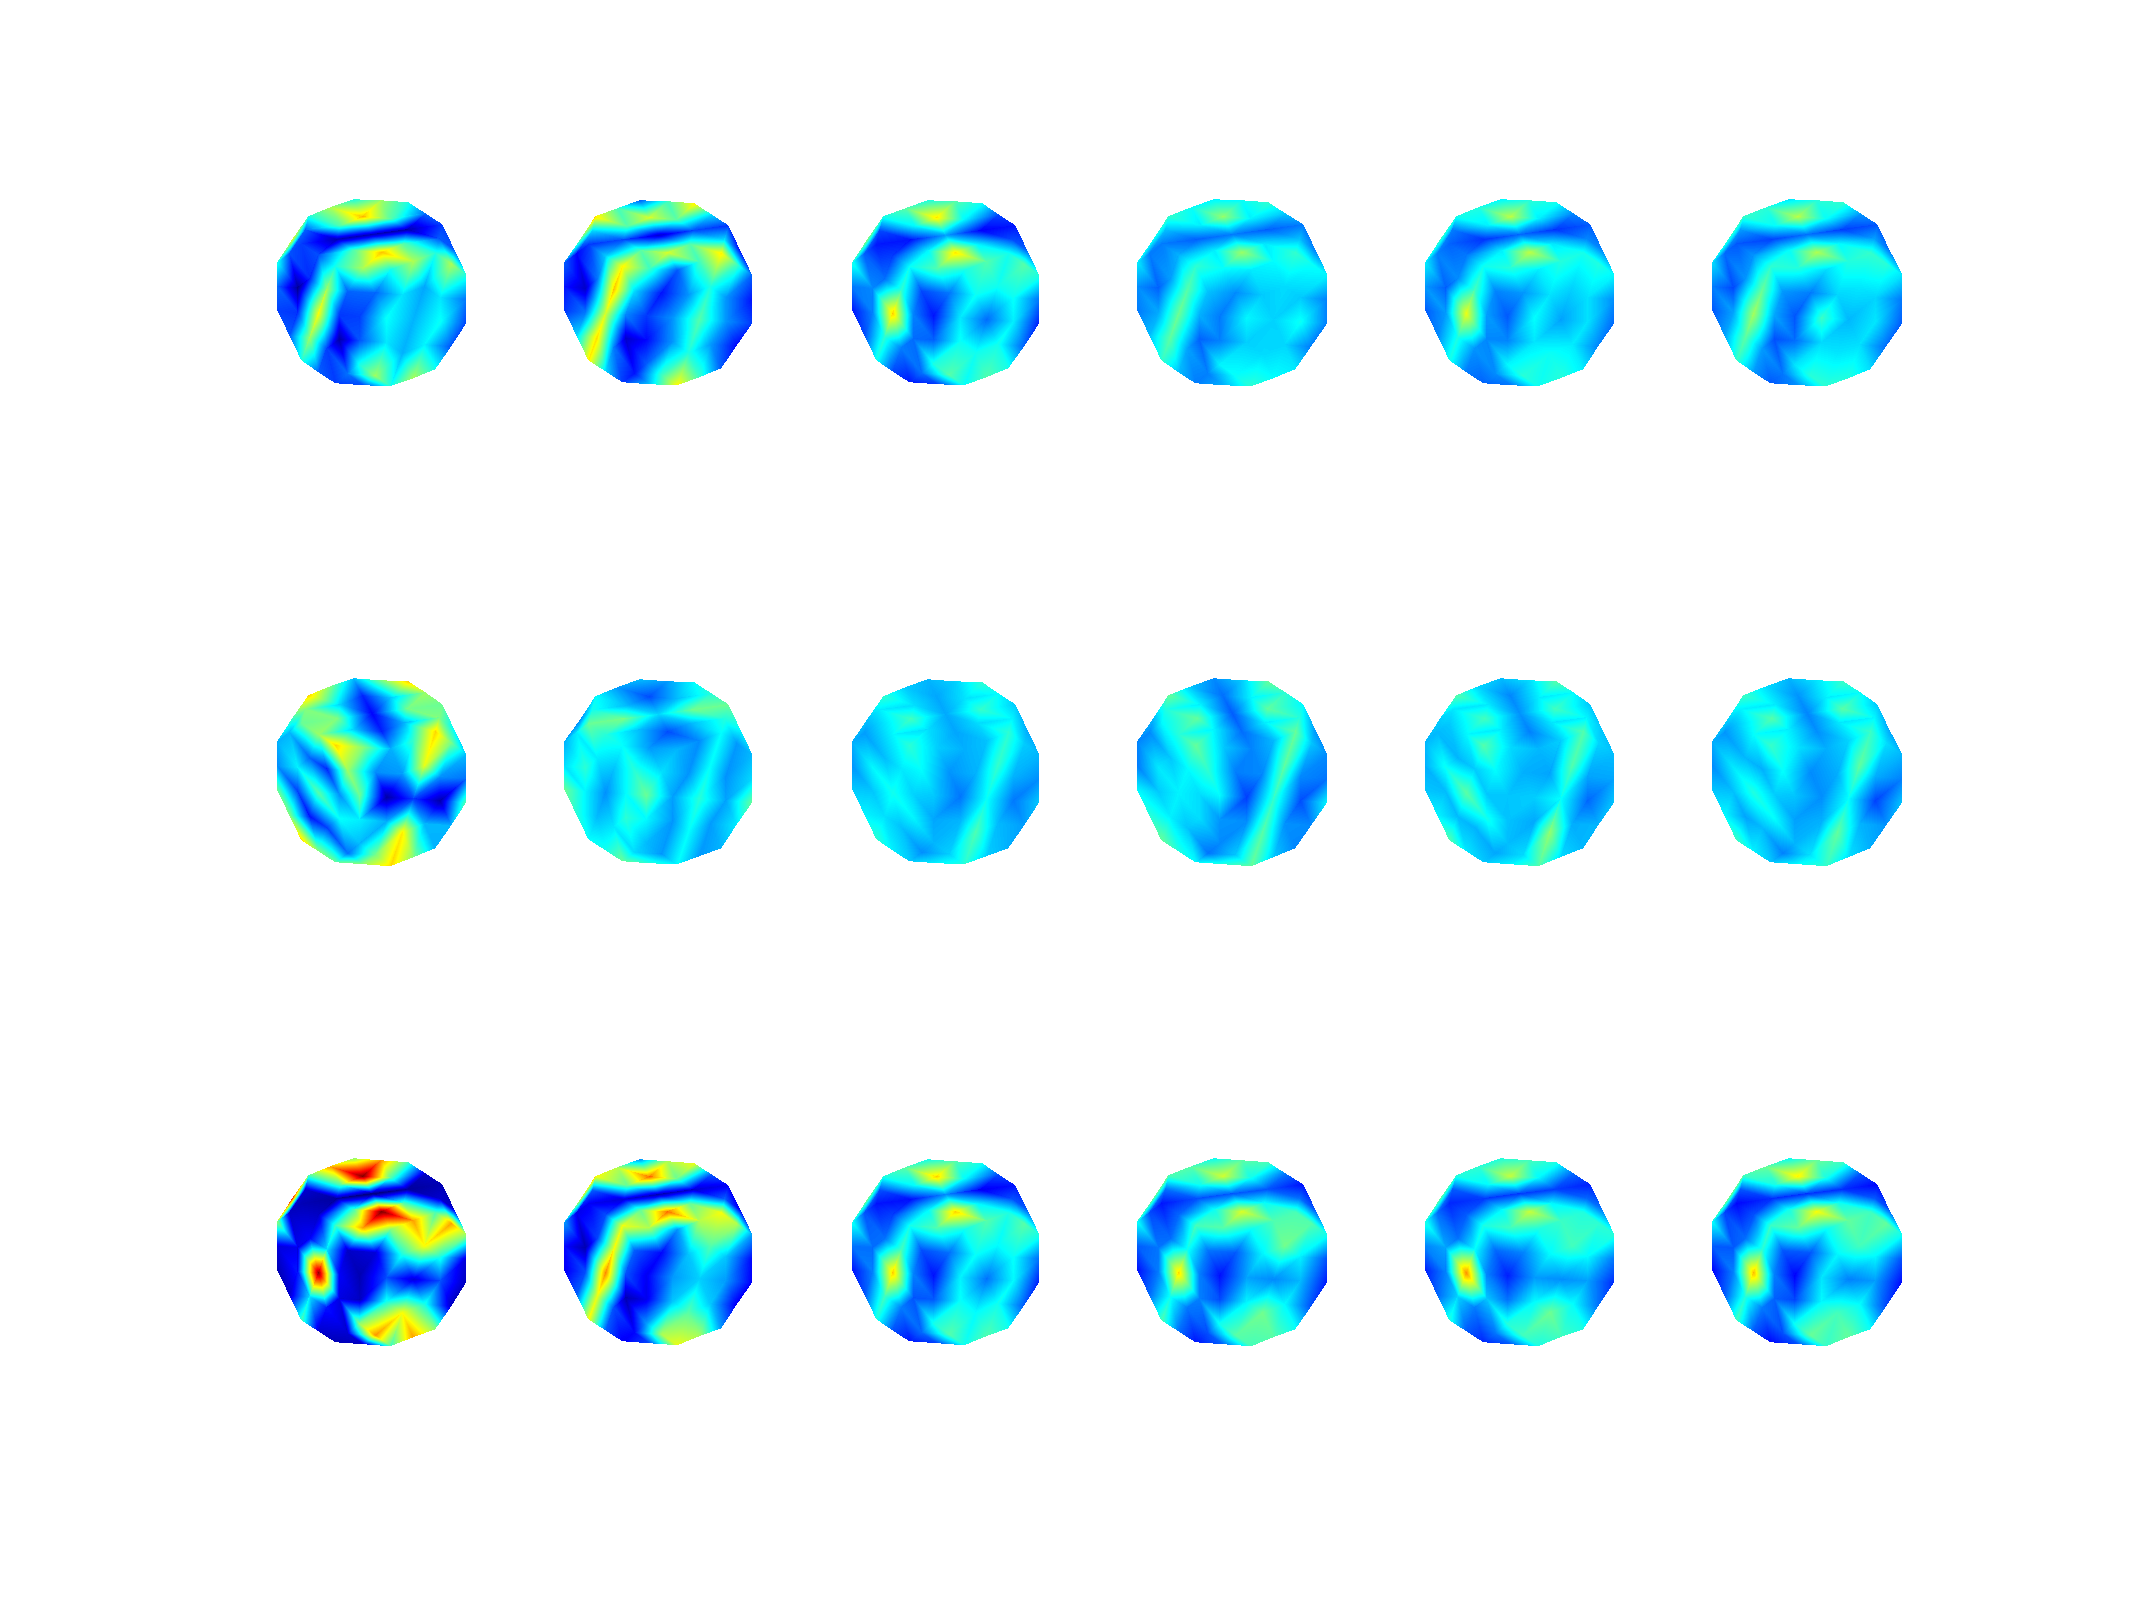

In [185]:
fname = 'varyLatentDimODFs'
np.savetxt(fname+'.txt',varyLatentDimODFs)

eng.plotODF_76(fname+'.txt',fname+'.png',6,nargout=0)

Image(filename=fname+'.png')

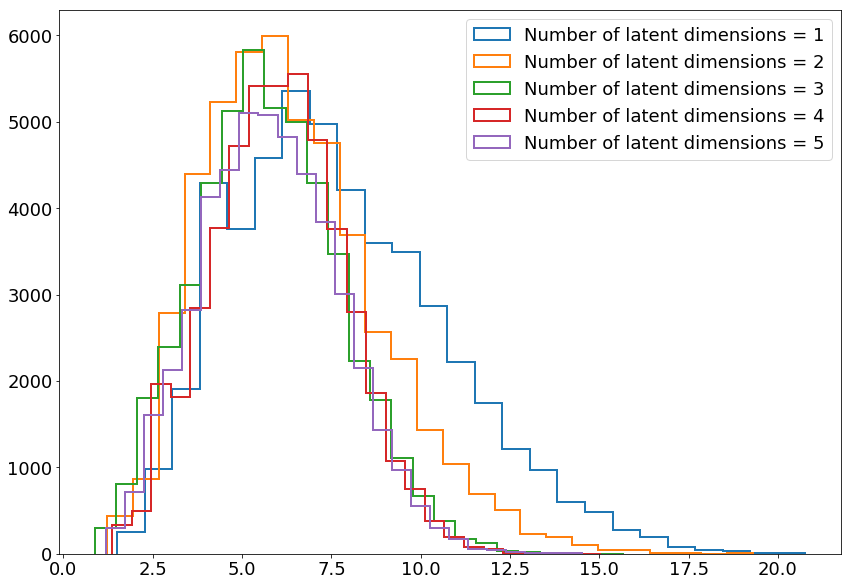

In [559]:
ODFinput = ODF_minussymmetry[validateset_rows,:]
ODFinput_scaled = ODFinput/np.max(ODF_minussymmetry)
rcParams['figure.figsize'] = (14.0,10.0)
rcParams['font.size']=18
E11_testset = compute_property(ODFinput, propMat)

#fig,ax = plt.subplots(1,1)

for ndim in range(1,6): 
    zm,zs,z = encoder_ndim[ndim].predict(ODFinput_scaled)
    ODFreturned_scaled = decoder_ndim[ndim].predict(zm)
    ODFreturned = (ODFreturned_scaled)*np.max(ODF_minussymmetry)
    
    E11_returned = compute_property(ODFreturned, propMat)

    error_ODF = np.linalg.norm(ODFreturned - ODFinput,axis=1)
    error_E11 = (E11_testset - E11_returned)
    
    plt.hist(error_ODF, bins = 25, histtype = 'step', linewidth=2, label = 'Number of latent dimensions = '+ str(ndim))

plt.legend()
plt.savefig('ODFL2error_validateset.png')
plt.show()

# Prediction
Use test data rows for prediction tasks

In [236]:
#predictRows = np.random.choice(testset_rows,10,replace=False)
predictRows = [90779,23468,93095,202500,186241,144773,162221,178408,17320,10814]
#np.savetxt('predictionInputRows.txt',predictRows)

In [237]:
predict_E11 = compute_property(ODF_minussymmetry[predictRows],propMat)

In [238]:
processing_info.iloc[predictRows]

p1  alpha1        p2  alpha2        p3  alpha3        p4  alpha4
90779   RollingY    -1.0  RollingZ    -0.5  RollingY     1.0  TensionZ     1.0
23468   TensionY    -1.0  TensionY     1.0  RollingX    -0.5  RollingY     1.0
93095   RollingZ    -0.5  RollingX     1.0  RollingY    -0.5  RollingY    -0.5
202500  TensionX    -1.0  TensionZ    -0.5  RollingZ     1.0  RollingY     0.5
186241  TensionY    -1.0  RollingX    -1.0  TensionZ    -1.0  TensionZ    -1.0
144773  TensionZ    -1.0  RollingZ    -1.0  RollingX     1.0  TensionZ     0.5
162221  TensionY    -1.0  TensionX    -0.5  TensionZ    -0.5  TensionX     1.0
178408  RollingX     0.5  RollingX    -1.0  TensionX     1.0  TensionZ    -1.0
17320   TensionX     1.0  TensionZ     1.0  TensionY     1.0  RollingY     0.5
10814   TensionX     0.5  RollingZ     0.5  RollingZ     0.5  TensionZ     0.5

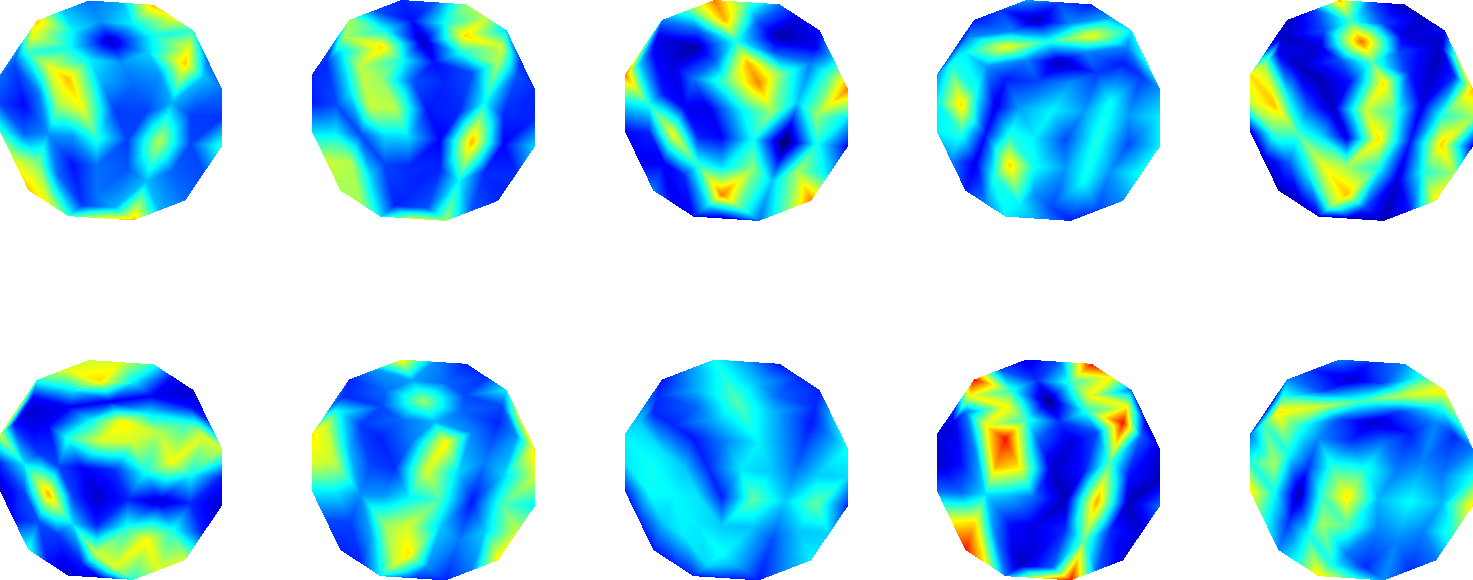

In [239]:
fname = 'prectictInput'

np.savetxt(fname+'.txt',ODF_minussymmetry[predictRows])

eng.plotODF_76_separate(fname+'.txt',fname+'.png',0,nargout=0)

#Image(filename=fname+'.png')

In [353]:
np.max(ODF_minussymmetry[predictRows])

6.914273733317135

In [354]:
np.min(ODF_minussymmetry[predictRows])

-0.326294720372741

In [617]:
ndim = 2

ODFinput = ODF_minussymmetry[predictRows,:]
ODF_scaled = ODFinput/np.max(ODF_minussymmetry)
z_meanpoint,zs,z = encoder_ndim[ndim].predict(ODF_scaled)

z_meanpredict, _, z = encoder_ndim[ndim].predict(ODF_minussymmetry[testset_rows]/np.max(ODF_minussymmetry))

ODFinput = ODF_minussymmetry[traininigset_rows]
ODFinput_scaled = ODFinput/np.max(ODF_minussymmetry)
zm,zs,z = encoder_ndim[ndim].predict(ODFinput_scaled)


195
262
63
87
56
58
562
622
114
188


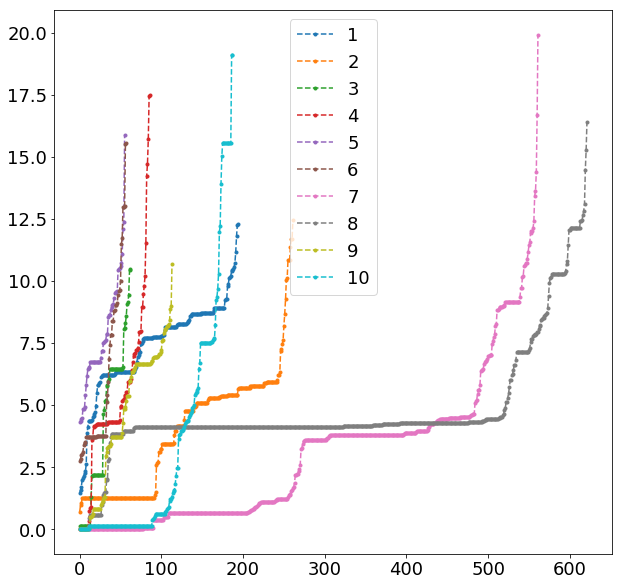

In [421]:

rcParams['figure.figsize'] = (10.0,10.0)
rcParams['font.size']=18

delta = 0.04
points_to_plot = {}
#fig,ax = plt.subplots(2,1)
fig,ax = plt.subplots(1,1)
indices_predicted = {}
windowODF_indices={}
for predictidx,pointtopredict in enumerate(z_meanpoint):
    indices = []
    latentspacerowsfromtrainingset = []
    for idx,point in enumerate(zm):
            if((point[0]-pointtopredict[0])**2+(point[1]-pointtopredict[1])**2<delta**2
                #and (point[1]-pointtopredict[1])**2+(point[1]-pointtopredict[1])**2<delta**2
                    #and point[2]>pointtopredict[2]-delta and point[2]<pointtopredict[2]+delta
              ):
                indices.append(traininigset_rows[idx])
                latentspacerowsfromtrainingset.append(idx)
    
    points_to_plot[predictidx] = zm[latentspacerowsfromtrainingset]
    
    print(len(indices))
    indices_predicted[predictidx] = indices
    
    
    matched_E11 = compute_property(ODF_minussymmetry[indices],propMat)

    error_ODF = np.linalg.norm(ODF_minussymmetry[indices] - ODF_minussymmetry[predictRows[predictidx]],axis=1)
    error_E11 = np.abs(matched_E11 - predict_E11[predictidx])

    sortingindices = np.argsort(error_ODF)
    ax.plot(error_ODF[sortingindices],'.--',label = int(predictidx+1))
    #ax[1].plot(error_ODF[sortingindices],'*-')
    #ax[0].plot(error_E11[sortingindices],'*-',label = int(predictidx+1))
    
    indices = np.array(indices)
    
    #print(processing_info.loc[indices])
    windowODF_indices[predictidx] = indices[sortingindices]
    
    if(len(indices)>10):
        indexneeded = np.random.choice(len(indices),5,replace=False)
    else:
        indexneeded = np.arange(len(indices))

#    np.savetxt('predict_'+str(predictRows[predictidx])+'.txt',windowODF[predictidx])
#    np.savetxt('plot_predict_'+str(predictRows[predictidx])+'.txt',windowODF[predictidx][indexneeded])
#    print(processing_info.loc[indices])

ax.legend()
plt.savefig('ODFerror_predict_2d.png')
plt.show()

195
262
63
87
56
58
562
622
114
188


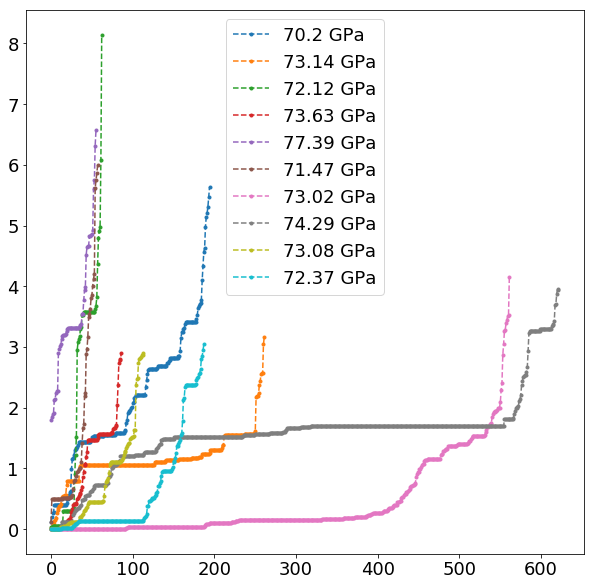

In [621]:

rcParams['figure.figsize'] = (10.0,10.0)
rcParams['font.size']=18

delta = 0.04
points_to_plot = {}
#fig,ax = plt.subplots(2,1)
fig,ax = plt.subplots(1,1)
indices_predicted = {}
windowODF_indices={}
for predictidx,pointtopredict in enumerate(z_meanpoint):
    indices = []
    latentspacerowsfromtrainingset = []
    for idx,point in enumerate(zm):
            if((point[0]-pointtopredict[0])**2+(point[1]-pointtopredict[1])**2<delta**2
                #and (point[1]-pointtopredict[1])**2+(point[1]-pointtopredict[1])**2<delta**2
                    #and point[2]>pointtopredict[2]-delta and point[2]<pointtopredict[2]+delta
              ):
                indices.append(traininigset_rows[idx])
                latentspacerowsfromtrainingset.append(idx)
    
    points_to_plot[predictidx] = zm[latentspacerowsfromtrainingset]
    
    print(len(indices))
    indices_predicted[predictidx] = indices
    
    
    matched_E11 = compute_property(ODF_minussymmetry[indices],propMat)

    error_ODF = np.linalg.norm(ODF_minussymmetry[indices] - ODF_minussymmetry[predictRows[predictidx]],axis=1)
    error_E11 = np.abs(matched_E11 - predict_E11[predictidx])

    sortingindices = np.argsort(error_E11)
    #ax.plot(error_ODF[sortingindices],'.--',label = int(predictidx+1))
    ax.plot(error_E11[sortingindices],'.--',label = str(round(predict_E11[predictidx], 2))+' GPa')
    #ax[1].plot(error_ODF[sortingindices],'*-')
    #ax[0].plot(error_E11[sortingindices],'*-',label = int(predictidx+1))
    
    indices = np.array(indices)
    
    #print(processing_info.loc[indices])
    windowODF_indices[predictidx] = indices[sortingindices]
    
    if(len(indices)>10):
        indexneeded = np.random.choice(len(indices),5,replace=False)
    else:
        indexneeded = np.arange(len(indices))

#    np.savetxt('predict_'+str(predictRows[predictidx])+'.txt',windowODF[predictidx])
#    np.savetxt('plot_predict_'+str(predictRows[predictidx])+'.txt',windowODF[predictidx][indexneeded])
#    print(processing_info.loc[indices])

ax.legend()
plt.savefig('ODFerror_predict_2d.png')
plt.show()

262
58


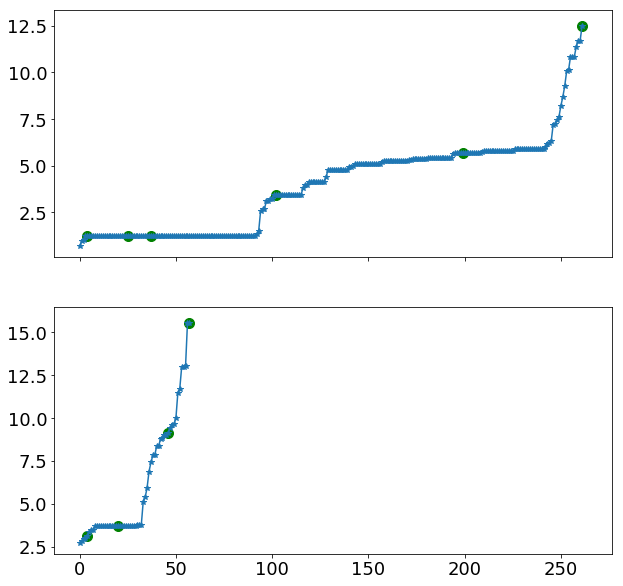

In [624]:

rcParams['figure.figsize'] = (10.0,10.0)
rcParams['font.size']=18

delta = 0.04
points_to_plot = {}
fig,ax = plt.subplots(2,1,sharex=True)
#fig,ax = plt.subplots(1,1)
indices_predicted = {}
windowODF={}
windowODF_indices={}
for plotID,predictidx in enumerate([1,5]):
    
    pointtopredict = z_meanpoint[predictidx]

    indices = []
    latentspacerowsfromtrainingset = []
    for idx,point in enumerate(zm):
            if((point[0]-pointtopredict[0])**2+(point[1]-pointtopredict[1])**2<delta**2
                #and (point[1]-pointtopredict[1])**2+(point[1]-pointtopredict[1])**2<delta**2
                    #and point[2]>pointtopredict[2]-delta and point[2]<pointtopredict[2]+delta
              ):
                indices.append(traininigset_rows[idx])
                latentspacerowsfromtrainingset.append(idx)
    
    points_to_plot[predictidx] = zm[latentspacerowsfromtrainingset]
    
    print(len(indices))
    indices_predicted[predictidx] = indices
    
    
    matched_E11 = compute_property(ODF_minussymmetry[indices],propMat)

    error_ODF = np.linalg.norm(ODF_minussymmetry[indices] - ODF_minussymmetry[predictRows[predictidx]],axis=1)
    error_E11 = np.abs(matched_E11 - predict_E11[predictidx])

    sortingindices = np.argsort(error_ODF)
    #ax.plot(error_ODF[sortingindices],'.--',label = int(predictidx+1))
    ax[plotID].plot(error_ODF[sortingindices],'*-')
    #ax[plotID].plot(error_E11[sortingindices],'*-',label = int(predictidx+1))
    
    indices = np.array(indices)
    
    #print(processing_info.loc[indices])
    windowODF[predictidx] = ODF_minussymmetry[indices[sortingindices]]
    windowODF_indices[predictidx] = indices[sortingindices]
    
    
    if plotID == 0:
        indexneeded = np.array([4,25,37,102,199,261])
    else:
        indexneeded = np.array([4,20,46,57])
        
    ax[plotID].scatter(indexneeded,error_ODF[sortingindices[indexneeded]],s=100,c='g')
#    ax[0].scatter(indexneeded,error_E11[sortingindices[indexneeded]],s=200)

    np.savetxt('predict_'+str(plotID)+'.txt',windowODF[predictidx])
    np.savetxt('plot_predict_'+str(plotID)+'.txt',windowODF[predictidx][indexneeded])
#    print(processing_info.loc[indices])

#ax[0].legend()
plt.savefig('ODFerror_predict_2,6_2d.png')
plt.show()

In [374]:
fname = 'plot_predict_'+str(0)
eng.plotODF_76_separate(fname+'.txt',fname+'.png',0,nargout=0)

In [375]:
fname = 'plot_predict_'+str(1)
eng.plotODF_76_separate(fname+'.txt',fname+'.png',0,nargout=0)

58
[71.35450694 70.97233177]
              p1  alpha1        p2  alpha2        p3  alpha3        p4  alpha4
70905   RollingZ -0.5     RollingX  1.0     RollingX  0.5     RollingY -0.5   
261130  RollingX  0.5     RollingX  1.0     TensionX  1.0     RollingZ -1.0   


/home/srihari/.local/lib/python3.6/site-packages/ipykernel_launcher.py:55: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


262
[73.16300449 72.75207599]
              p1  alpha1        p2  alpha2        p3  alpha3        p4  alpha4
131657  RollingY  1.0     RollingY  0.5     TensionZ -0.5     RollingX -0.5   
45492   TensionZ  0.5     RollingZ  0.5     TensionZ  1.0     TensionY  1.0   


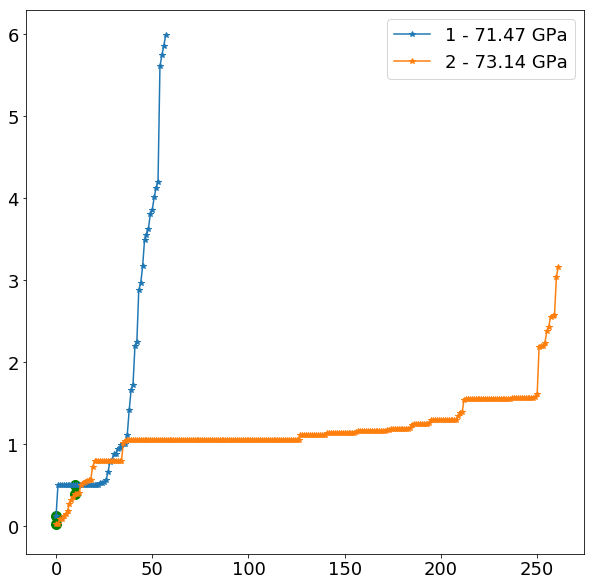

In [646]:

rcParams['figure.figsize'] = (10.0,10.0)
rcParams['font.size']=18

delta = 0.04
points_to_plot = {}
#fig,ax = plt.subplots(2,1,sharex=True)
fig,ax = plt.subplots(1,1)
indices_predicted = {}
windowODF={}
windowODF_indices={}
for plotID,predictidx in enumerate([5,1]):
    
    pointtopredict = z_meanpoint[predictidx]

    indices = []
    latentspacerowsfromtrainingset = []
    for idx,point in enumerate(zm):
            if((point[0]-pointtopredict[0])**2+(point[1]-pointtopredict[1])**2<delta**2
                #and (point[1]-pointtopredict[1])**2+(point[1]-pointtopredict[1])**2<delta**2
                    #and point[2]>pointtopredict[2]-delta and point[2]<pointtopredict[2]+delta
              ):
                indices.append(traininigset_rows[idx])
                latentspacerowsfromtrainingset.append(idx)
    
    points_to_plot[predictidx] = zm[latentspacerowsfromtrainingset]
    
    print(len(indices))
    indices_predicted[predictidx] = indices
    
    
    matched_E11 = compute_property(ODF_minussymmetry[indices],propMat)

    error_ODF = np.linalg.norm(ODF_minussymmetry[indices] - ODF_minussymmetry[predictRows[predictidx]],axis=1)
    error_E11 = np.abs(matched_E11 - predict_E11[predictidx])

    sortingindices = np.argsort(error_E11)
    ax.plot(error_E11[sortingindices],'*-',label = str(plotID+1)+' - '+str(round(predict_E11[predictidx], 2))+' GPa')
    #ax[plotID].plot(error_ODF[sortingindices],'*-')
    #ax[plotID].plot(error_E11[sortingindices],'*-',label = str(round(predict_E11[predictidx], 2))+' GPa')
    
    indices = np.array(indices)
    
    #print(processing_info.loc[indices])
    windowODF[predictidx] = ODF_minussymmetry[indices[sortingindices]]
    windowODF_indices[predictidx] = indices[sortingindices]
        
#    ax[plotID].scatter(indexneeded,error_ODF[sortingindices[indexneeded]],s=100,c='g')
#    ax[0].scatter(indexneeded,error_E11[sortingindices[indexneeded]],s=200)

    indexneeded = [0,10]
    ax.scatter(indexneeded,error_E11[sortingindices[indexneeded]],s=100,c='g')
    
    np.savetxt('E_x_plot_predict_'+str(plotID)+'.txt',windowODF[predictidx][indexneeded])
    print(matched_E11[[sortingindices[indexneeded]]])
    print(processing_info.loc[indices[sortingindices[indexneeded]]])

ax.legend()
plt.savefig('ExError_predict_1,5_2d.png')
plt.show()

In [647]:
fname = 'E_x_plot_predict_'+str(0)
eng.plotODF_76_separate(fname+'.txt',fname+'.png',0,nargout=0)

In [648]:
fname = 'E_x_plot_predict_'+str(1)
eng.plotODF_76_separate(fname+'.txt',fname+'.png',0,nargout=0)

In [275]:
pd.set_option('display.max_rows', None)

In [543]:
processing_info.loc[windowODF_indices[1][[4,25,37,102,199,261]]]

p1  alpha1          p2  alpha2             p3  alpha3  \
201070  Tension X      0.5     Rolling YX -0.5     Rolling ZY     0.5      
41536   Compression X  1.0     Rolling YX -0.5     Rolling ZY     1.0      
8803    Rolling YX    -0.5     Tension X   1.0     Rolling ZY     1.0      
276669  Rolling YX    -1.0     Rolling ZY  1.0     Rolling YX     0.5      
200716  Rolling ZY     1.0     Tension Z   0.5     Compression Z  0.5      
218481  Tension Z      1.0     Tension Z   1.0     Tension Z      1.0      

                   p4  alpha4  
201070  Rolling ZY     0.5     
41536   NaN           NaN      
8803    NaN           NaN      
276669  NaN           NaN      
200716  Compression X  1.0     
218481  Tension Y      0.5

In [544]:
predict_table_2d_1 = processing_info.loc[windowODF_indices[1][[4,25,37,102,199,261]]].reset_index(drop=True)

predict_table_2d_1.index = np.arange(1, len(predict_table_2d_1) + 1)

predict_table_2d_1.to_latex('predict_table_2d_1.tex')

In [545]:
predict_table_2d_1

p1  alpha1          p2  alpha2             p3  alpha3  \
1  Tension X      0.5     Rolling YX -0.5     Rolling ZY     0.5      
2  Compression X  1.0     Rolling YX -0.5     Rolling ZY     1.0      
3  Rolling YX    -0.5     Tension X   1.0     Rolling ZY     1.0      
4  Rolling YX    -1.0     Rolling ZY  1.0     Rolling YX     0.5      
5  Rolling ZY     1.0     Tension Z   0.5     Compression Z  0.5      
6  Tension Z      1.0     Tension Z   1.0     Tension Z      1.0      

              p4  alpha4  
1  Rolling ZY     0.5     
2  NaN           NaN      
3  NaN           NaN      
4  NaN           NaN      
5  Compression X  1.0     
6  Tension Y      0.5

In [549]:
processing_info.loc[windowODF_indices[1][[4,20,46,57]]]

p1  alpha1             p2  alpha2             p3  alpha3  \
201070  Tension X      0.5     Rolling YX    -0.5     Rolling ZY     0.5      
167539  Tension X      0.5     Compression X  0.5     Rolling YX    -0.5      
1686    Compression X  0.5     Rolling YX    -0.5     Rolling ZY     1.0      
38854   Rolling YX    -0.5     Tension X      1.0     Compression X  0.5      

                   p4  alpha4  
201070  Rolling ZY     0.5     
167539  Rolling ZY     1.0     
1686    Compression X  0.5     
38854   Rolling ZY     1.0

In [550]:
predict_table_2d_2 = processing_info.loc[windowODF_indices[5][[4,20,46,57]]].reset_index(drop=True)

predict_table_2d_2.index = np.arange(1, len(predict_table_2d_2) + 1)

predict_table_2d_2.to_latex('predict_table_2d_2.tex')

In [551]:
predict_table_2d_2

p1  alpha1             p2  alpha2             p3  alpha3  \
1  Rolling YX     1.0     Rolling XZ     0.5     Compression Z  0.5      
2  Rolling YX     0.5     Rolling YX     1.0     Rolling XZ    -1.0      
3  Tension Y      0.5     Rolling ZY    -0.5     Compression Z  1.0      
4  Compression Z  1.0     Compression Y  0.5     Rolling YX     1.0      

              p4  alpha4  
1  Rolling XZ    -1.0     
2  NaN           NaN      
3  Rolling YX     1.0     
4  Compression Z  1.0

90779
23468
93095
202500
186241
144773
162221
178408
17320
10814


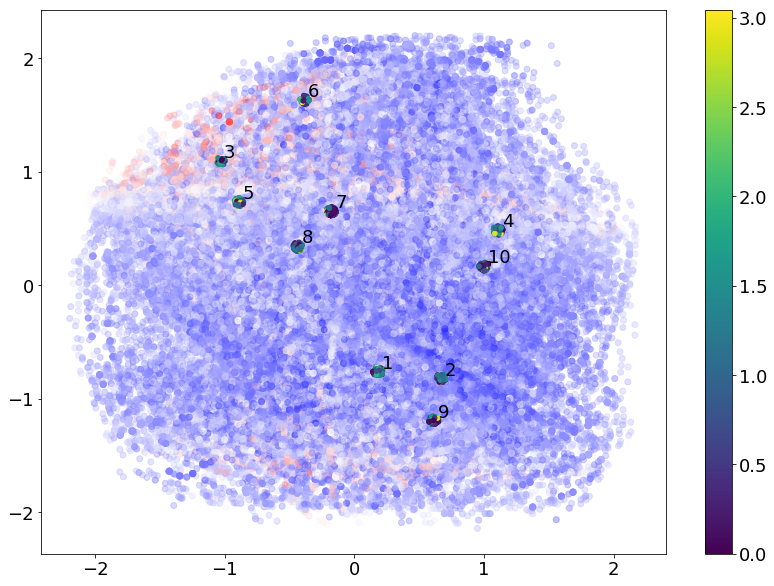

In [259]:
plt.scatter(zm[:,0],zm[:,1],alpha = 0.3,c=E_11[traininigset_rows],cmap=cm.bwr)

for predictidx,pointtopredict in enumerate(z_meanpoint):
    matched_E11 = compute_property(ODF_minussymmetry[indices_predicted[predictidx]],propMat)

    error_E11 = abs(matched_E11 - predict_E11[predictidx])
    
    print(predictRows[predictidx])
    
    plt.scatter(pointtopredict[0],pointtopredict[1],s=100)
    plt.scatter(points_to_plot[predictidx][:,0],points_to_plot[predictidx][:,1],c=error_E11,s=20)
    plt.annotate(str(predictidx+1), (pointtopredict[0]+0.03, pointtopredict[1]+0.03))
    
plt.colorbar()
plt.savefig('2dpredict_points_latentspace.png')    
plt.show()

90779
23468
93095
202500
186241
144773
162221
178408
17320
10814


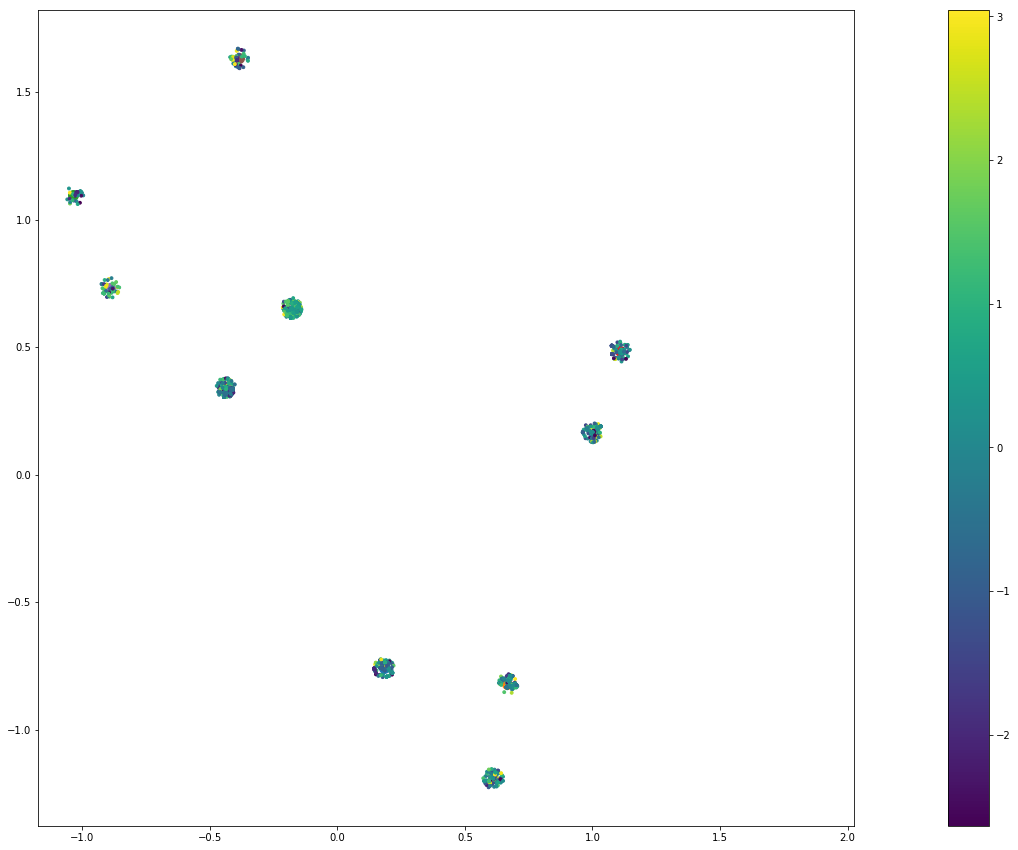

In [243]:
for predictidx,pointtopredict in enumerate(z_meanpoint):
    matched_E11 = compute_property(ODF_minussymmetry[indices_predicted[predictidx]],propMat)

    error_E11 = (matched_E11 - predict_E11[predictidx])
    
    print(predictRows[predictidx])
    
    plt.scatter(pointtopredict[0],pointtopredict[1],s=100)
    plt.scatter(points_to_plot[predictidx][:,0],points_to_plot[predictidx][:,1],c=error_E11,s=8)
    #plt.annotate(str(predictidx), (pointtopredict[0]+0.02, pointtopredict[1]+0.02))
    
plt.colorbar()
plt.show()

In [552]:
ndim = 3

ODFinput = ODF_minussymmetry[predictRows,:]
ODF_scaled = ODFinput/np.max(ODF_minussymmetry)
z_meanpoint,zs,z = encoder_ndim[ndim].predict(ODF_scaled)

z_meanpredict, _, z = encoder_ndim[ndim].predict(ODF_minussymmetry[testset_rows]/np.max(ODF_minussymmetry))

ODFinput = ODF_minussymmetry[traininigset_rows]
ODFinput_scaled = ODFinput/np.max(ODF_minussymmetry)
zm,zs,z = encoder_ndim[ndim].predict(ODFinput_scaled)


807
976
171
306
279
242
679
2232
235
467


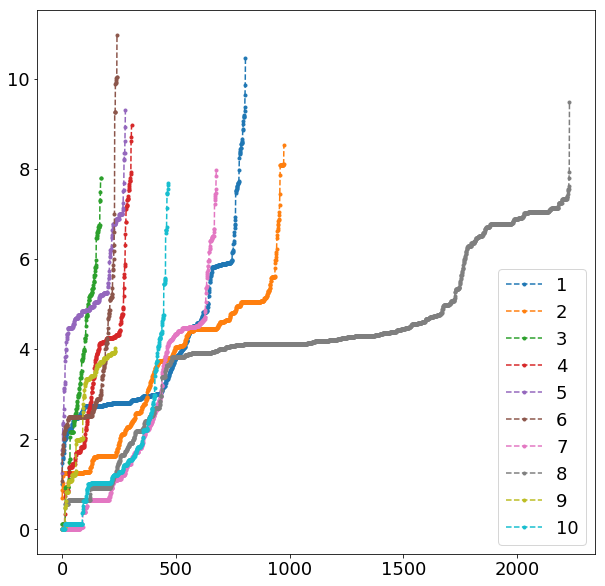

In [426]:
rcParams['figure.figsize'] = (10.0,10.0)
rcParams['font.size']=18

delta = 0.2

#fig,ax = plt.subplots(2,1)
fig,ax = plt.subplots(1,1)
indices_predicted = {}
windowODF_indices={}
points_to_plot = {}
for predictidx,pointtopredict in enumerate(z_meanpoint):
    indices = []
    latentspacerowsfromtrainingset = []
    for idx,point in enumerate(zm):
            if((point[0]-pointtopredict[0])**2+(point[1]-pointtopredict[1])**2 \
               +(point[2]-pointtopredict[2])**2<delta**2
               #point[0]>pointtopredict[0]-delta and point[0]<pointtopredict[0]+delta
               # and point[1]>pointtopredict[1]-delta and point[1]<pointtopredict[1]+delta
               #     and point[2]>pointtopredict[2]-delta and point[2]<pointtopredict[2]+delta
              ):
                indices.append(traininigset_rows[idx])
                latentspacerowsfromtrainingset.append(idx)
    
    points_to_plot[predictidx] = zm[latentspacerowsfromtrainingset]
    
    print(len(indices))
    indices_predicted[predictidx] = indices
    
    
    matched_E11 = compute_property(ODF_minussymmetry[indices],propMat)

    error_ODF = np.linalg.norm(ODF_minussymmetry[indices] - ODF_minussymmetry[predictRows[predictidx]],axis=1)
    error_E11 = np.abs(matched_E11 - predict_E11[predictidx])

    sortingindices = np.argsort(error_ODF)
    ax.plot(error_ODF[sortingindices],'.--',label = int(predictidx+1))
    #ax[1].plot(error_ODF[sortingindices],'*-')
    #ax[0].plot(error_E11[sortingindices],'*-',label = int(predictidx+1))
    
    indices = np.array(indices)
    
    #print(processing_info.loc[indices])
    windowODF_indices[predictidx] = indices[sortingindices]
    
    if(len(indices)>10):
        indexneeded = np.random.choice(len(indices),5,replace=False)
    else:
        indexneeded = np.arange(len(indices))

#    np.savetxt('predict_'+str(predictRows[predictidx])+'.txt',windowODF[predictidx])
#    np.savetxt('plot_predict_'+str(predictRows[predictidx])+'.txt',windowODF[predictidx][indexneeded])
#    print(processing_info.loc[indices])

ax.legend()
plt.savefig('ODFerror_predict_3d.png')
plt.show()

976
242


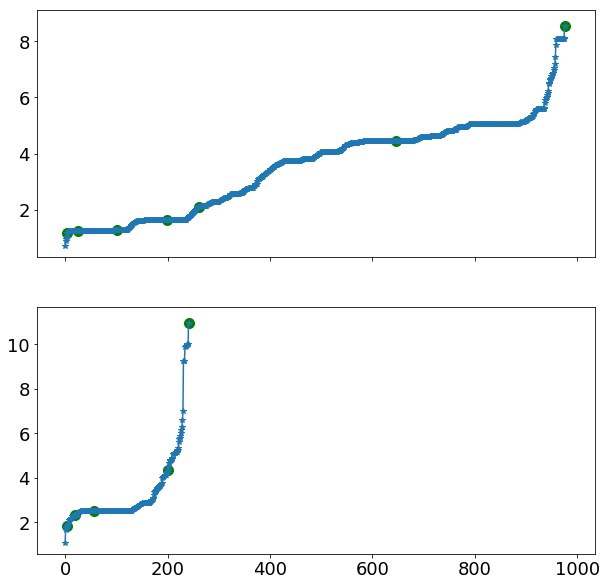

In [553]:

rcParams['figure.figsize'] = (10.0,10.0)
rcParams['font.size']=18

delta = 0.2
points_to_plot = {}
fig,ax = plt.subplots(2,1,sharex=True)
#fig,ax = plt.subplots(1,1)
indices_predicted = {}
windowODF={}
windowODF_indices={}
for plotID,predictidx in enumerate([1,5]):
    
    pointtopredict = z_meanpoint[predictidx]

    indices = []
    latentspacerowsfromtrainingset = []
    for idx,point in enumerate(zm):
            if((point[0]-pointtopredict[0])**2+(point[1]-pointtopredict[1])**2 \
               +(point[2]-pointtopredict[2])**2<delta**2
               #point[0]>pointtopredict[0]-delta and point[0]<pointtopredict[0]+delta
               # and point[1]>pointtopredict[1]-delta and point[1]<pointtopredict[1]+delta
               #     and point[2]>pointtopredict[2]-delta and point[2]<pointtopredict[2]+delta
              ):
                indices.append(traininigset_rows[idx])
                latentspacerowsfromtrainingset.append(idx)
    
    points_to_plot[predictidx] = zm[latentspacerowsfromtrainingset]
    
    print(len(indices))
    indices_predicted[predictidx] = indices
    
    
    matched_E11 = compute_property(ODF_minussymmetry[indices],propMat)

    error_ODF = np.linalg.norm(ODF_minussymmetry[indices] - ODF_minussymmetry[predictRows[predictidx]],axis=1)
    error_E11 = np.abs(matched_E11 - predict_E11[predictidx])

    sortingindices = np.argsort(error_ODF)
    #ax.plot(error_ODF[sortingindices],'.--',label = int(predictidx+1))
    ax[plotID].plot(error_ODF[sortingindices],'*-')
    #ax[plotID].plot(error_E11[sortingindices],'*-',label = int(predictidx+1))
    
    indices = np.array(indices)
    
    #print(processing_info.loc[indices])
    windowODF[predictidx] = ODF_minussymmetry[indices[sortingindices]]
    windowODF_indices[predictidx] = indices[sortingindices]
    
    
    if plotID == 0:
        indexneeded = np.array([4,25,102,199,261,645,975])
    else:
        indexneeded = np.array([4,20,57,200,241])
        
    ax[plotID].scatter(indexneeded,error_ODF[sortingindices[indexneeded]],s=100,c='g')
#    ax[0].scatter(indexneeded,error_E11[sortingindices[indexneeded]],s=200)

    np.savetxt('3dpredict_'+str(plotID)+'.txt',windowODF[predictidx])
    np.savetxt('3dplot_predict_'+str(plotID)+'.txt',windowODF[predictidx][indexneeded])
#    print(processing_info.loc[indices])

#ax[0].legend()
plt.savefig('ODFerror_predict_2,9_3d.png')
plt.show()

In [391]:
fname = '3dplot_predict_'+str(0)
eng.plotODF_76_separate(fname+'.txt',fname+'.png',0,nargout=0)

In [392]:
fname = '3dplot_predict_'+str(1)
eng.plotODF_76_separate(fname+'.txt',fname+'.png',0,nargout=0)

In [554]:
predict_table_3d_1 = processing_info.loc[windowODF_indices[1][[4,25,102,199,261,645,975]]].reset_index(drop=True)

predict_table_3d_1.index = np.arange(1, len(predict_table_3d_1) + 1)

predict_table_3d_1.to_latex('predict_table_3d_1.tex')

In [555]:
predict_table_3d_1

p1  alpha1             p2  alpha2             p3  alpha3  \
1  Compression Y  0.5     Rolling ZY     1.0     Rolling YX    -0.5      
2  Compression X  1.0     Tension X      0.5     Rolling YX    -0.5      
3  Rolling ZY     0.5     Rolling YX    -0.5     Compression X  1.0      
4  Rolling ZY     1.0     Rolling YX    -0.5     Tension X      1.0      
5  Tension Z      1.0     Compression Z  1.0     Rolling ZY     1.0      
6  Tension X      1.0     Tension Z      1.0     Tension X      0.5      
7  Rolling XZ    -0.5     Tension Z      1.0     Tension Z      1.0      

              p4  alpha4  
1  Tension Y      0.5     
2  Rolling ZY     1.0     
3  Rolling ZY     0.5     
4  Compression X  1.0     
5  Rolling YX    -0.5     
6  Rolling ZY     0.5     
7  Rolling YX     0.5

In [556]:
predict_table_3d_2 = processing_info.loc[windowODF_indices[5][[4,20,57,200,241]]].reset_index(drop=True)

predict_table_3d_2.index = np.arange(1, len(predict_table_3d_2) + 1)

predict_table_3d_2.to_latex('predict_table_3d_2.tex')

In [557]:
predict_table_3d_2

p1  alpha1          p2  alpha2             p3  alpha3  \
1  Rolling XZ    -1.0     Rolling YX  1.0     Tension Z      0.5      
2  Rolling XZ    -1.0     Rolling YX -0.5     Rolling YX     1.0      
3  Compression X  1.0     Rolling XZ -1.0     Rolling YX     1.0      
4  Compression Z  1.0     Tension Y   0.5     Rolling XZ    -0.5      
5  Tension Y      1.0     Tension Y   1.0     Compression Z  1.0      

              p4  alpha4  
1  Compression Z  0.5     
2  Rolling YX     0.5     
3  Compression X  0.5     
4  Rolling YX     0.5     
5  Compression Z  1.0

# Error histogram

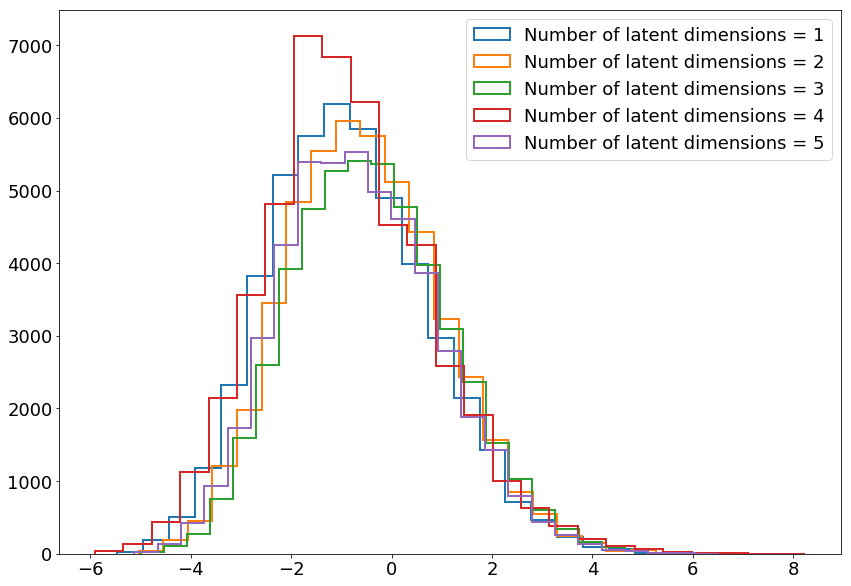

In [558]:
ODFinput = ODF_minussymmetry[validateset_rows,:]
ODFinput_scaled = ODFinput/np.max(ODF_minussymmetry)
rcParams['figure.figsize'] = (14.0,10.0)
rcParams['font.size']=18
E11_testset = compute_property(ODFinput, propMat)

#fig,ax = plt.subplots(1,1)

for ndim in range(1,6): 
    zm,zs,z = encoder_ndim[ndim].predict(ODFinput_scaled)
    ODFreturned_scaled = decoder_ndim[ndim].predict(zm)
    ODFreturned = (ODFreturned_scaled)*np.max(ODF_minussymmetry)
    
    E11_returned = compute_property(ODFreturned, propMat)

    error_ODF = np.linalg.norm(ODFreturned - ODFinput,axis=1)
    error_E11 = (E11_testset - E11_returned)
    
#    plt.hist(error_ODF, bins = 25, histtype = 'step', linewidth=2, label = 'Number of latent dimensions = '+ str(ndim))
    plt.hist(error_E11, bins = 25, histtype = 'step', linewidth=2, label = 'Number of latent dimensions = '+ str(ndim))
#    ax[1].hist(error_E11, bins = 50, histtype = 'step', label = 'Number of latent dimensions = '+ str(ndim))
#    ax[0].hist(error_ODF, bins = 50, histtype = 'stepfilled', alpha=0.5, label = 'Number of latent dimensions = '+ str(ndim))
#    ax[1].hist(error_E11, bins = 50, histtype = 'stepfilled', alpha=0.3, label = 'Number of latent dimensions = '+ str(ndim))

#pl.rc('xtick', labelsize=20) 
#matplotlib.rc('ytick', labelsize=20)
#plt.xlabel('Ex difference between input ODF and decoded ODF',fontsize=18)
plt.legend()
plt.savefig('Exerror_validateset.png')
plt.show()